# News Category Classification

## Importing the libraries

In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

In [2]:
# Making plots folder
os.makedirs("plots", exist_ok=True)

In [3]:
# For repratibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Function to save plots
def save_plot(path, dpi=160, bbox_inches="tight"):
    base = os.path.basename(path)
    name, ext = os.path.splitext(base)
    if ext == "":
        ext = ".jpg" # Setting defualt extension
    safe_path = re.sub(r"[^A-Za-z0-9]+", "_", name).strip("_") + ext
    full_path = os.path.join("plots", safe_path)
    plt.savefig(full_path, dpi=dpi, bbox_inches=bbox_inches)
    print("Saved : ", full_path)

## Loading the AG News Dataset

In [5]:
train_path = "data/train.csv"
test_path = "data/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [6]:
df_train.columns = ["label", "title", "text"]
df_test.columns = ["label", "title", "text"]

In [7]:
# Combining the title and body
df_train["full_text"] = (df_train["title"].fillna("")) + " " + df_train["text"].fillna("").str.strip()
df_test["full_text"] = (df_test["title"].fillna("")) + " " + df_test["text"].fillna("").str.strip()

df_train.head()

,label,title,text,full_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [8]:
# Mapping numerics labels to readable names
# AGNews : 1 = World, 2 = Sports, 3 = Business, 4 = Sci/Tech
label_map = {1 : "World", 2 : "Sports", 3 : "Business", 4 : "SciTech"}
df_train["label_name"] = df_train["label"].map(label_map)
df_test["label_name"] = df_test["label"].map(label_map)

df_train.head()

,label,title,text,full_text,label_name
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",Business


In [9]:
print("Train size :", len(df_train))
print("Test size :", len(df_test))
print("\nTrain label distribuation :\n", df_train["label_name"].value_counts())

Train size : 120000
Test size : 7600

Train label distribuation :
 label_name
Business    30000
SciTech     30000
Sports      30000
World       30000
Name: count, dtype: int64


## Splitting the training set into training and validation set

In [10]:
X = df_train["full_text"].values
y = df_train["label_name"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)

X_test = df_test["full_text"].values
y_test = df_test["label_name"].values

## TF-IDF and Logistic Regression

In [11]:
tf_idf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2), # Unigrams and bigrams
    max_df=0.9, # ignore terms in >90% docs
    min_df=5 # ignore very rare terms
)

log_reg = LogisticRegression(
    max_iter=200, # allow more iterations to converge
    n_jobs= -1 if hasattr(LogisticRegression, "n_jobs") else None,
    multi_class="ovr" # one-vs-rest
)

In [12]:
# Vectorize
X_train_tf_idf = tf_idf.fit_transform(X_train)
X_val_tf_idf = tf_idf.transform(X_val)
X_test_tf_idf = tf_idf.transform(X_test)

In [13]:
# Training
log_reg.fit(X_train_tf_idf, y_train)

c:\Elevvo_NLP_Internship\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'ovr'


In [14]:
# Validating
val_pred = log_reg.predict(X_val_tf_idf)
val_acc = accuracy_score(y_val, val_pred)
print(f"Validation accuracy : {val_acc:.4f}")

print("\nValidation Classification Report:\n")
print(classification_report(y_val, val_pred, digits=4))

Validation accuracy : 0.9219

Validation Classification Report:

              precision    recall  f1-score   support

    Business     0.8986    0.8904    0.8945      4500
     SciTech     0.8965    0.9031    0.8998      4500
      Sports     0.9599    0.9833    0.9715      4500
       World     0.9320    0.9109    0.9213      4500

    accuracy                         0.9219     18000
   macro avg     0.9218    0.9219    0.9218     18000
weighted avg     0.9218    0.9219    0.9218     18000



### Confusion Matrix for validation set

Saved :  plots\logistic_regression_validation_confusion_matrix.jpg


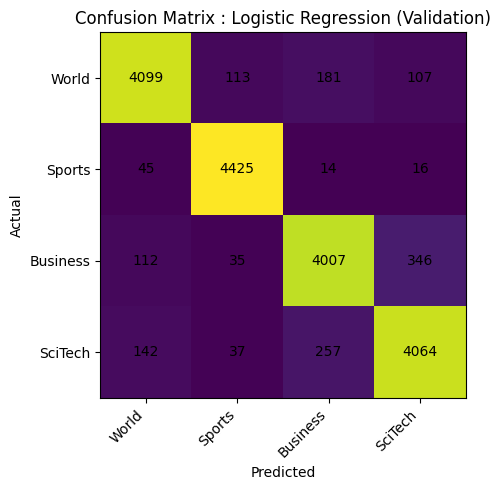

In [15]:
cm = confusion_matrix(y_val, val_pred, labels=list(label_map.values()))

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix : Logistic Regression (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=range(len(label_map)), labels=list(label_map.values()), rotation=45, ha="right")
plt.yticks(ticks=range(len(label_map)), labels=list(label_map.values()))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
save_plot("logistic_regression_validation_confusion_matrix.jpg")
plt.show()

### Predicting on Testing set

In [16]:
test_pred = log_reg.predict(X_test_tf_idf)
test_acc = accuracy_score(y_test, test_pred)
print(f"Validation accuracy : {test_acc:.4f}")

print("\nValidation Classification Report:\n")
print(classification_report(y_test, test_pred, digits=4))

Validation accuracy : 0.9164

Validation Classification Report:

              precision    recall  f1-score   support

    Business     0.8877    0.8816    0.8846      1900
     SciTech     0.8952    0.8942    0.8947      1900
      Sports     0.9507    0.9842    0.9672      1900
       World     0.9313    0.9058    0.9184      1900

    accuracy                         0.9164      7600
   macro avg     0.9162    0.9164    0.9162      7600
weighted avg     0.9162    0.9164    0.9162      7600



### Confusion Matrix for Tetsing set

Saved :  plots\logistic_regression_testing_confusion_matrix.jpg


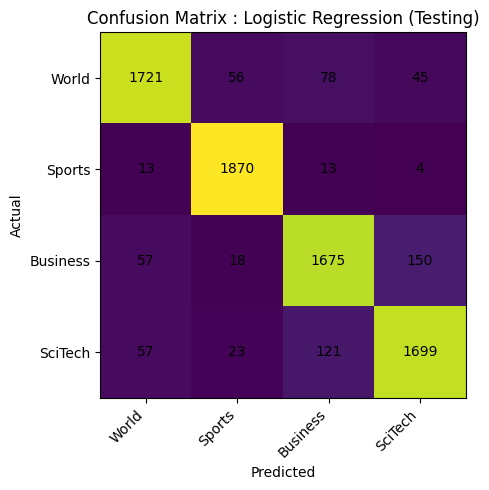

In [17]:
cm = confusion_matrix(y_test, test_pred, labels=list(label_map.values()))

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix : Logistic Regression (Testing)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=range(len(label_map)), labels=list(label_map.values()), rotation=45, ha="right")
plt.yticks(ticks=range(len(label_map)), labels=list(label_map.values()))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
save_plot("logistic_regression_testing_confusion_matrix.jpg")
plt.show()

## Word clouds per category

In [18]:
# Combine all docs per class for the word cloud
texts_by_class = (
    df_train.groupby("label_name")["full_text"].apply(lambda s : " ".join(s.values)).to_dict()
)

Saved :  plots\Word_Cloud_Business.jpg


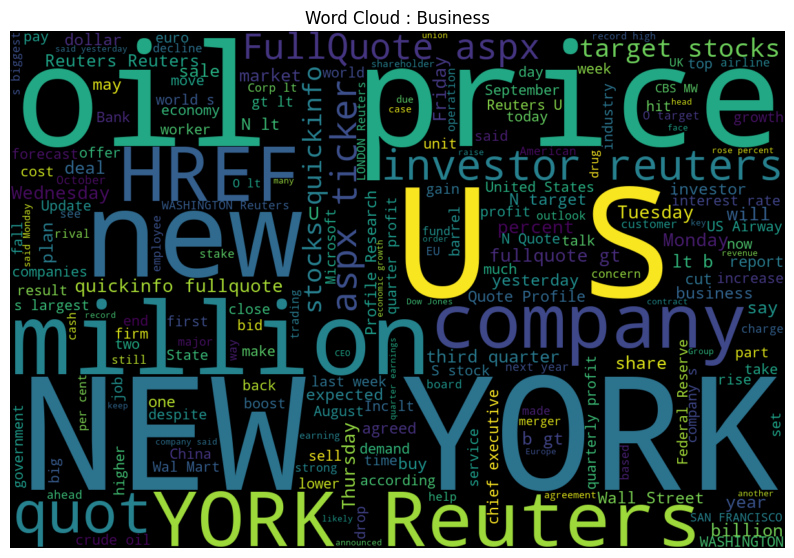

Saved :  plots\Word_Cloud_SciTech.jpg


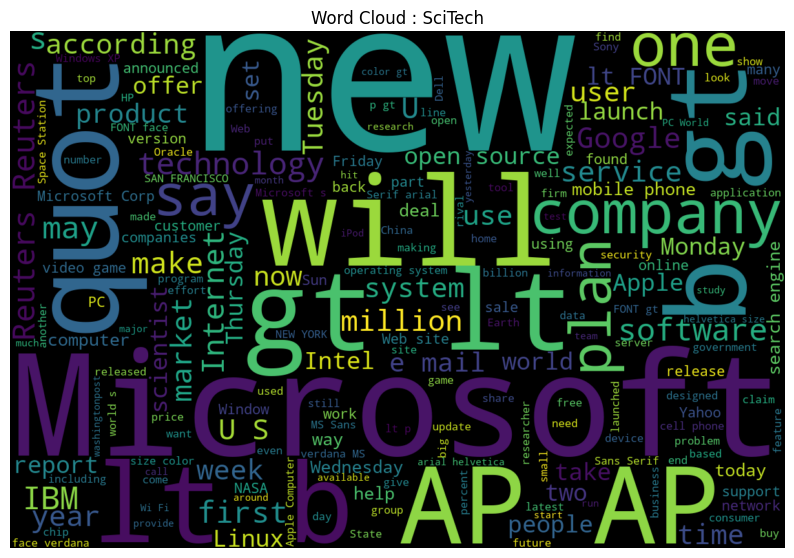

Saved :  plots\Word_Cloud_Sports.jpg


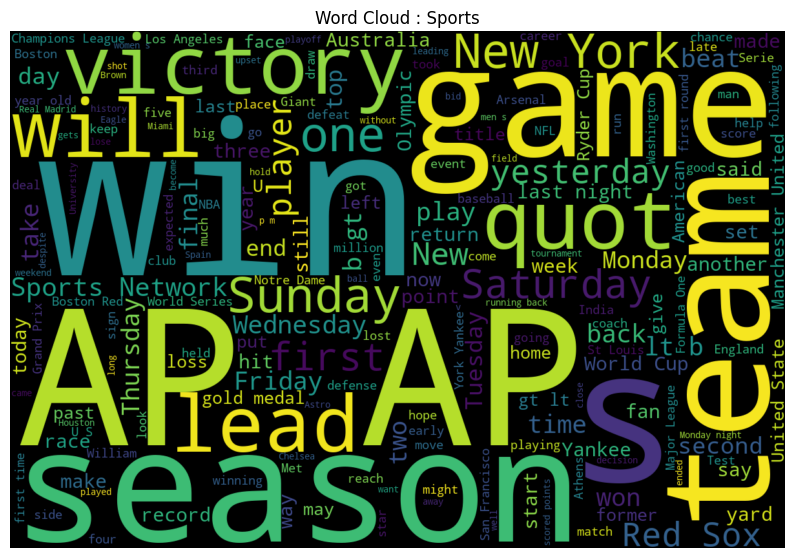

Saved :  plots\Word_Cloud_World.jpg


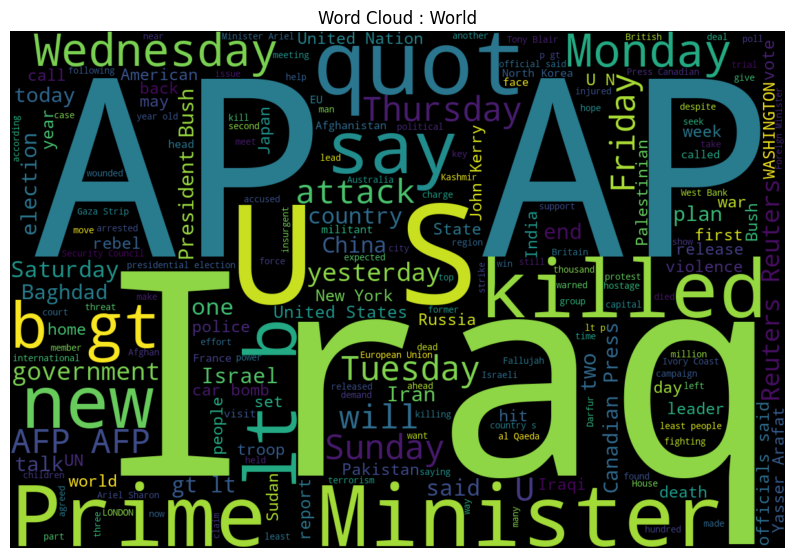

In [19]:
for cls, big_text in texts_by_class.items():
    wc = WordCloud(
        width=1200,
        height=800,
        background_color="black",
        stopwords=set(WordCloud().stopwords)
    ).generate(big_text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud : {cls}")
    save_plot(f"Word Cloud : {cls}")
    plt.show()

## Neural Networks
For NN, it's better to tokenize sequences rather than feed TF-IDF

### Tokenize


In [20]:
VOCAB_SIZE = 40000 # cap vocab for speed or memory
MAX_LEN = 120 # truncate or pad to this many tokens

In [21]:
tok = Tokenizer(num_words = VOCAB_SIZE, oov_token = "<OOV>")
tok.fit_on_texts(X_train)

In [22]:
X_train_seq = tok.texts_to_sequences(X_train)
X_val_seq = tok.texts_to_sequences(X_val)
X_test_seq = tok.texts_to_sequences(X_test)

In [23]:
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

### Encode labels as integers 0, ..., 3 for keras

In [24]:
classes = sorted(df_train["label_name"].unique().tolist())
cls_to_idx = {c:i for i, c in enumerate(classes)}
idx_to_cls = {i:c for c, i in cls_to_idx.items()}

In [25]:
y_train_idx = np.array([cls_to_idx[c] for c in y_train])
y_val_idx = np.array([cls_to_idx[c] for c in y_val])
y_test_idx = np.array([cls_to_idx[c] for c in y_test])

In [26]:
y_train_oh = utils.to_categorical(y_train_idx, num_classes=len(classes))
y_val_oh = utils.to_categorical(y_val_idx, num_classes=len(classes))
y_test_oh = utils.to_categorical(y_test_idx, num_classes=len(classes))

### NN Model

In [27]:
EMBED_DIM = 64

nn = models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(classes), activation="softmax")
])

nn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

nn.summary()

c:\Elevvo_NLP_Internship\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training with early stopping

In [28]:
es = callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy")

history = nn.fit(
    X_train_pad, y_train_oh,
    validation_data=(X_val_pad, y_val_oh),
    epochs=12,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

Epoch 1/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7390 - loss: 0.7707 - val_accuracy: 0.8930 - val_loss: 0.3405
Epoch 2/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9040 - loss: 0.3083 - val_accuracy: 0.9154 - val_loss: 0.2677
Epoch 3/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9212 - loss: 0.2500 - val_accuracy: 0.9207 - val_loss: 0.2441
Epoch 4/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9305 - loss: 0.2159 - val_accuracy: 0.9233 - val_loss: 0.2340
Epoch 5/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9395 - loss: 0.1901 - val_accuracy: 0.9242 - val_loss: 0.2302
Epoch 6/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9462 - loss: 0.1685 - val_accuracy: 0.9246 - val_loss: 0.2303
Epoch 7/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9523 - loss: 0.1516 - val_accuracy: 0.9234 - val_loss: 0.2368
Epoch 8/12
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9564 - loss: 0.1381 - va

## Plotting Training curves

Saved :  plots\keras_nn_accuracy.jpg


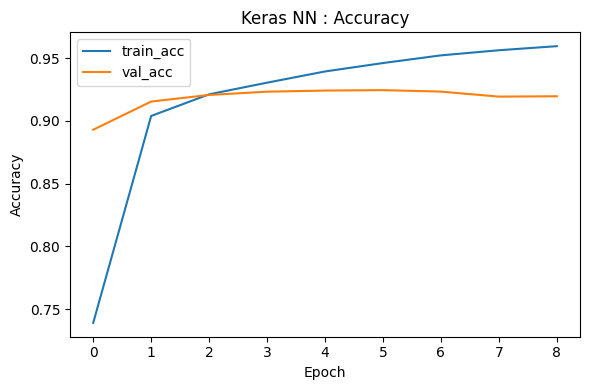

In [29]:
# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Keras NN : Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
save_plot("keras_nn_accuracy.jpg")
plt.show()

Saved :  plots\keras_nn_loss.jpg


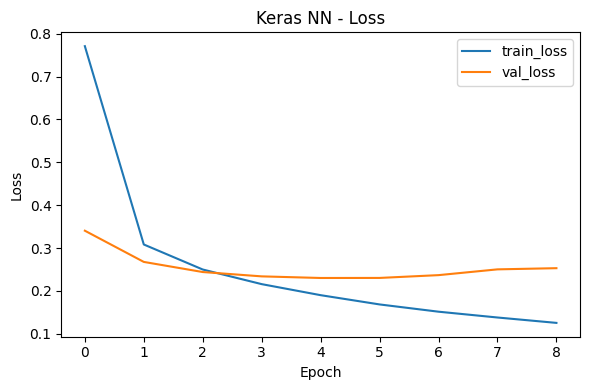

In [30]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Keras NN - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
save_plot("keras_nn_loss.jpg")
plt.show()

## Evaluating the testing set

In [31]:
# Evaluating NN
test_loss, test_acc = nn.evaluate(X_test_pad, y_test_oh, verbose=0)
print(f"NN Test accuracy : {test_acc:.4f}")

NN Test accuracy : 0.9199


In [32]:
# Predicting NN
proba = nn.predict(X_test_pad, verbose=0)
pred_idx = proba.argmax(axis=1)
pred_cls = [idx_to_cls[i] for i in pred_idx]

print("\nNN Test classification report:\n")
print(classification_report(y_test, pred_cls, digits=4, labels=classes))


NN Test classification report:

              precision    recall  f1-score   support

    Business     0.8827    0.8953    0.8889      1900
     SciTech     0.8935    0.9005    0.8970      1900
      Sports     0.9604    0.9816    0.9708      1900
       World     0.9438    0.9021    0.9225      1900

    accuracy                         0.9199      7600
   macro avg     0.9201    0.9199    0.9198      7600
weighted avg     0.9201    0.9199    0.9198      7600



Saved :  plots\keras_nn_confusion_matrix.jpg


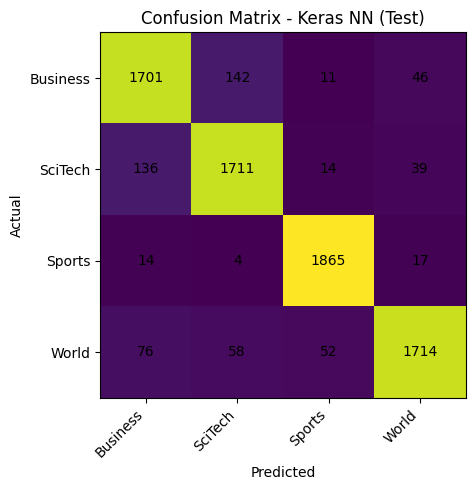

In [33]:
# Confusion matrix for NN
cm_nn = confusion_matrix(y_test, pred_cls, labels=classes)

plt.figure(figsize=(6,5))
plt.imshow(cm_nn, interpolation='nearest')
plt.title("Confusion Matrix - Keras NN (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45, ha="right")
plt.yticks(ticks=range(len(classes)), labels=classes)
for i in range(cm_nn.shape[0]):
    for j in range(cm_nn.shape[1]):
        plt.text(j, i, cm_nn[i, j], ha="center", va="center")
plt.tight_layout()
save_plot("keras_nn_confusion_matrix.jpg")
plt.show()